<a href="https://colab.research.google.com/github/zakariasamy/8-puzzle/blob/master/Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Setup and Introduction
- This cell installs necessary libraries and provides an overview of the project.

In [1]:
# @title 1. Setup and Introduction
# -*- coding: utf-8 -*-
"""
Final Thesis Implementation: Domain Knowledge guided Attentional Training
Author: Zakaria Samy (with Gemini AI Assistant)
Supervisor: Prof. Dr. Nahla Belal, Dr. Mohamed Seifelden

This notebook implements and validates the core concepts of the thesis proposal.
It is divided into two main parts:
1.  Training and evaluating a standard CNN as a baseline.
2.  Training and evaluating our novel Knowledge-Guided CNN.
Finally, it runs a series of comparative "stress tests" to prove the superiority of the proposed framework.
"""

# Import all necessary libraries
import pandas as pd
import numpy as np
import glob
import os
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Reshape
from tensorflow.keras import Model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
import warnings
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
print("TensorFlow Version:", tf.__version__)
print("✅ All libraries imported successfully.")

TensorFlow Version: 2.19.0
✅ All libraries imported successfully.


2. Data Loading and Preparation
* This cell handles mounting your Google Drive, merging the 8 CSV files, and performing all the necessary preprocessing steps.

In [2]:
# @title 2. Data Loading and Preparation
print("\n" + "="*50)
print("STAGE 1: DATA LOADING AND PREPARATION 📂")
print("="*50)

# 1. Mount Google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_MOUNTED = True
except ImportError:
    DRIVE_MOUNTED = False
    print("Could not mount Google Drive. Assuming data is in the local Colab environment.")

# 2. Merge all CSV files into one DataFrame
# --- IMPORTANT: Change this path to the exact folder you created in your Google Drive! ---
drive_path = '/content/drive/MyDrive/Thesis_Dataset/'

if DRIVE_MOUNTED and os.path.exists(drive_path):
    all_files = glob.glob(os.path.join(drive_path, "*.csv"))
else:
    print(f"Warning: Google Drive path '{drive_path}' not found. Looking for data in the current directory.")
    all_files = glob.glob("*.csv")

if not all_files:
    raise ValueError("FATAL ERROR: No CSV files found. Please upload your dataset or check the 'drive_path' variable.")

list_of_dataframes = []
for filename in all_files:
    print(f'Reading {os.path.basename(filename)}...')
    df = pd.read_csv(filename)
    list_of_dataframes.append(df)

print("\nCombining all files...")
df = pd.concat(list_of_dataframes, ignore_index=True)
print(f"Initial dataset shape: {df.shape}")

# 3. Data Cleaning
print("\nStarting data cleaning...")
df.columns = df.columns.str.strip()
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
print(f"Shape after cleaning: {df.shape}")

# 4. Feature and Label Separation
X = df.drop('Label', axis=1)
y_text = df['Label']

# 5. Label Encoding
print("\nEncoding labels...")
le = LabelEncoder()
y = le.fit_transform(y_text)
num_classes = len(le.classes_)
print(f"Found {num_classes} unique classes:")
for i, class_name in enumerate(le.classes_):
    print(f"  {i}: {class_name}")

y_categorical = to_categorical(y, num_classes=num_classes)

# 6. Feature Scaling
print("\nScaling features...")
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# 7. Train-Test Split
print("\nSplitting data into training and testing sets (80/20)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y
)

# Convert to TensorFlow tensors for efficiency
X_train_tf = tf.convert_to_tensor(X_train.values, dtype=tf.float32)
X_test_tf = tf.convert_to_tensor(X_test.values, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test, dtype=tf.float32)

print(f"Training features shape: {X_train_tf.shape}")
print(f"Testing features shape: {X_test_tf.shape}")
print("\n✅ Data preparation complete.")


STAGE 1: DATA LOADING AND PREPARATION 📂
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv...
Reading Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv...
Reading Friday-WorkingHours-Morning.pcap_ISCX.csv...
Reading Monday-WorkingHours.pcap_ISCX.csv...
Reading Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv...
Reading Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv...
Reading Tuesday-WorkingHours.pcap_ISCX.csv...
Reading Wednesday-workingHours.pcap_ISCX.csv...

Combining all files...
Initial dataset shape: (2830743, 79)

Starting data cleaning...
Shape after cleaning: (2520798, 79)

Encoding labels...
Found 15 unique classes:
  0: BENIGN
  1: Bot
  2: DDoS
  3: DoS GoldenEye
  4: DoS Hulk
  5: DoS Slowhttptest
  6: DoS slowloris
  7: FTP-Patator
  8: Heartbleed
  9: Infiltration
  10: PortScan
  11: SSH-Patator
  12: Web Attack � 

3: Expert Knowledge Annotation (Simulated)
* This cell simulates the output of your Stage 1 methodology. Based on a review of feature importance from multiple academic papers, we now define a much more detailed set of "Knowledge Vectors."

In [3]:
# @title 3. Expert Knowledge Annotation (Simulated - V2 with Deeper Knowledge)
print("\n" + "="*50)
print("STAGE 2: EXPERT KNOWLEDGE ANNOTATION (SIMULATED) 🧠")
print("="*50)

feature_names = X.columns.tolist()
num_features = len(feature_names)
default_vector = np.ones(num_features, dtype=np.float32)
knowledge_vectors_np = {}

# Add robust normalization for label matching
import re

def normalize_text(s: str) -> str:
    s = s.lower().replace('�', ' ')
    s = re.sub(r'[^a-z0-9]+', ' ', s)
    return re.sub(r'\s+', ' ', s).strip()

def find_idx(name):
    try:
        return [c.strip() for c in feature_names].index(name)
    except ValueError:
        return -1 # Silently fail if feature not found

# --- Create a more comprehensive knowledge base based on research ---

# For DDoS & DoS Hulk (Flood Attacks)
flood_vector = default_vector.copy()
important_features = ['Total Fwd Packets', 'Fwd Packets/s', 'Bwd Packets/s', 'Average Packet Size', 'Packet Length Mean']
unimportant_features = ['Fwd PSH Flags', 'Fwd URG Flags', 'Flow IAT Max', 'Flow IAT Min', 'FIN Flag Count']
for fname in important_features:
    idx = find_idx(fname);
    if idx != -1: flood_vector[idx] = 10.0
for fname in unimportant_features:
    idx = find_idx(fname);
    if idx != -1: flood_vector[idx] = 0.2
knowledge_vectors_np['ddos'] = flood_vector
knowledge_vectors_np['hulk'] = flood_vector
knowledge_vectors_np['goldeneye'] = flood_vector

# DoS Slowloris & Slowhttptest
slow_vector = default_vector.copy()
important_features = ['Flow Duration', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Std', 'Total Fwd Packets']
unimportant_features = ['Fwd Packet Length Max', 'Average Packet Size', 'Packet Length Variance']
for fname in important_features:
    idx = find_idx(fname);
    if idx != -1: slow_vector[idx] = 5.0
for fname in unimportant_features:
    idx = find_idx(fname);
    if idx != -1: slow_vector[idx] = 0.2
knowledge_vectors_np['slowloris'] = slow_vector
knowledge_vectors_np['slowhttptest'] = slow_vector

# PortScan
portscan_vector = default_vector.copy()
important_features = ['Destination Port', 'SYN Flag Count', 'FIN Flag Count', 'RST Flag Count', 'Flow IAT Mean']
unimportant_features = ['Fwd Packet Length Max', 'Flow Duration', 'Total Fwd Packets', 'Idle Mean']
for fname in important_features:
    idx = find_idx(fname);
    if idx != -1: portscan_vector[idx] = 5.0
for fname in unimportant_features:
    idx = find_idx(fname);
    if idx != -1: portscan_vector[idx] = 0.2
knowledge_vectors_np['portscan'] = portscan_vector

# Brute Force (FTP/SSH/Web)
brute_force_vector = default_vector.copy()
important_features = ['Subflow Fwd Packets', 'Flow Packets/s', 'PSH Flag Count']
misleading_features = ['Flow IAT Max', 'Idle Mean']
for fname in important_features:
    idx = find_idx(fname);
    if idx != -1: brute_force_vector[idx] = 3.0
for fname in misleading_features:
    idx = find_idx(fname);
    if idx != -1: brute_force_vector[idx] = 0.1
knowledge_vectors_np['patator'] = brute_force_vector
knowledge_vectors_np['brute force'] = brute_force_vector

# --- NEW VECTORS FOR RARE ATTACKS ---

# Botnet
# Logic: Botnets often use periodic, small "heartbeat" packets to a C&C server.
bot_vector = default_vector.copy()
important_features = ['Flow IAT Mean', 'Flow IAT Std', 'Idle Mean', 'Packet Length Mean']
unimportant_features = ['Destination Port', 'Fwd Packet Length Max'] # Port can be common (80/443), Max length is irrelevant
for fname in important_features:
    idx = find_idx(fname);
    if idx != -1: bot_vector[idx] = 4.0
for fname in unimportant_features:
    idx = find_idx(fname);
    if idx != -1: bot_vector[idx] = 0.3
knowledge_vectors_np['bot'] = bot_vector

# Infiltration
# Logic: Attacker is inside, trying to blend in. Look for long durations or unusual data transfers.
infiltration_vector = default_vector.copy()
important_features = ['Flow Duration', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets']
misleading_features = ['Source Port', 'Destination Port'] # Often uses common ports to hide
for fname in important_features:
    idx = find_idx(fname);
    if idx != -1: infiltration_vector[idx] = 4.0
for fname in misleading_features:
    idx = find_idx(fname);
    if idx != -1: infiltration_vector[idx] = 0.1
knowledge_vectors_np['infiltration'] = infiltration_vector

# Web Attacks: SQL Injection & XSS
# Logic: The attack is in the packet payload, which we can't see. We must rely on secondary effects,
# like an unusually large response from the server after the injection.
web_app_attack_vector = default_vector.copy()
important_features = ['Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Avg Bwd Segment Size']
unimportant_features = ['Total Fwd Packets', 'Flow IAT Mean']
for fname in important_features:
    idx = find_idx(fname);
    if idx != -1: web_app_attack_vector[idx] = 5.0
for fname in unimportant_features:
    idx = find_idx(fname);
    if idx != -1: web_app_attack_vector[idx] = 0.3
knowledge_vectors_np['sql injection'] = web_app_attack_vector
knowledge_vectors_np['xss'] = web_app_attack_vector

# Heartbleed (TLS heartbeat-based anomaly)
heartbleed_vector = default_vector.copy()
important_features = ['Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Avg Bwd Segment Size', 'Flow Bytes/s']
unimportant_features = ['Destination Port', 'Source Port', 'Total Fwd Packets']
for fname in important_features:
    idx = find_idx(fname);
    if idx != -1: heartbleed_vector[idx] = 6.0
for fname in unimportant_features:
    idx = find_idx(fname);
    if idx != -1: heartbleed_vector[idx] = 0.2
knowledge_vectors_np['heartbleed'] = heartbleed_vector

# --- Assign vectors to all classes (robust matching) ---
final_knowledge_vectors = []
for class_name in le.classes_:
    cname_norm = normalize_text(class_name)
    vec_to_add = default_vector
    assigned = False

    # Explicit handling for Web Attack variants
    if 'web attack' in cname_norm:
        if 'sql' in cname_norm:
            vec_to_add = knowledge_vectors_np.get('sql injection', default_vector)
            assigned = True
        elif 'xss' in cname_norm:
            vec_to_add = knowledge_vectors_np.get('xss', default_vector)
            assigned = True
        elif 'brute' in cname_norm:
            vec_to_add = knowledge_vectors_np.get('brute force', default_vector)
            assigned = True

    if not assigned:
        for key, vec in knowledge_vectors_np.items():
            if normalize_text(key) in cname_norm:
                vec_to_add = vec
                assigned = True
                break

    if not assigned:
        print(f"Assigned default (neutral) vector to class '{class_name}'")
    else:
        print(f"Assigned specific knowledge vector to class '{class_name}'")

    final_knowledge_vectors.append(vec_to_add)

knowledge_vectors_tf = tf.convert_to_tensor(np.array(final_knowledge_vectors), dtype=tf.float32)
print("\n✅ Comprehensive knowledge vectors created.")


STAGE 2: EXPERT KNOWLEDGE ANNOTATION (SIMULATED) 🧠
Assigned default (neutral) vector to class 'BENIGN'
Assigned specific knowledge vector to class 'Bot'
Assigned specific knowledge vector to class 'DDoS'
Assigned specific knowledge vector to class 'DoS GoldenEye'
Assigned specific knowledge vector to class 'DoS Hulk'
Assigned specific knowledge vector to class 'DoS Slowhttptest'
Assigned specific knowledge vector to class 'DoS slowloris'
Assigned specific knowledge vector to class 'FTP-Patator'
Assigned specific knowledge vector to class 'Heartbleed'
Assigned specific knowledge vector to class 'Infiltration'
Assigned specific knowledge vector to class 'PortScan'
Assigned specific knowledge vector to class 'SSH-Patator'
Assigned specific knowledge vector to class 'Web Attack � Brute Force'
Assigned specific knowledge vector to class 'Web Attack � Sql Injection'
Assigned specific knowledge vector to class 'Web Attack � XSS'

✅ Comprehensive knowledge vectors created.


4. Baseline Model Training and Evaluation
* This cell defines, trains, and evaluates the standard CNN which will serve as our baseline for comparison.

In [4]:
# @title 4. Baseline Model Training and Evaluation
print("\n" + "="*80)
print("PART 1: BASELINE MODEL IMPLEMENTATION (STANDARD TRAINING)")
print("="*80)

# --- HYPERPARAMETERS ---
EPOCHS = 5
BATCH_SIZE = 256
LEARNING_RATE = 0.001

# --- CREATE WEIGHTS DIRECTORY ---
weights_dir = '/content/drive/MyDrive/Thesis_Weights/'
if DRIVE_MOUNTED:
    os.makedirs(weights_dir, exist_ok=True)
    print(f"✅ Weights directory created/verified: {weights_dir}")

# 1.1 Model Architecture (Standard CNN)
def create_cnn_model(input_shape, num_classes):
    """Creates a standard 1D CNN model for NIDS."""
    model = Sequential([
        Input(shape=(input_shape,)),
        Reshape((input_shape, 1)),
        Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

# 1.2 Training the Baseline Model
print("\n--- Training Baseline Model ---")
input_shape = X_train_tf.shape[1]
baseline_model = create_cnn_model(input_shape, num_classes)

# Check for existing baseline weights
baseline_weights_path = os.path.join(weights_dir, 'baseline_model.weights.h5') if DRIVE_MOUNTED else 'baseline_model.weights.h5'
if os.path.exists(baseline_weights_path):
    print(f"🔄 Loading existing baseline model weights from: {baseline_weights_path}")
    baseline_model.load_weights(baseline_weights_path)
else:
    print("📝 No existing baseline weights found. Training from scratch...")
    baseline_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss=CategoricalCrossentropy(), metrics=['accuracy'])

    # Compute class weights to mitigate imbalance
    from collections import Counter

    labels_int = np.argmax(y_train_tf.numpy(), axis=1)
    class_counts = Counter(labels_int)
    max_count = max(class_counts.values())
    class_weight = {cls: max_count / cnt for cls, cnt in class_counts.items()}
    print("Class weights:", class_weight)

    # Build per-sample weights for training (comment out for unbalanced training)
    # sample_weights = np.array([class_weight[i] for i in labels_int], dtype=np.float32)
    sample_weights = None  # Set to None to disable class weighting

    baseline_history = baseline_model.fit(X_train_tf, y_train_tf, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test_tf, y_test_tf), sample_weight=sample_weights, verbose=1)

    # Save the trained weights
    baseline_model.save_weights(baseline_weights_path)
    print(f"💾 Baseline model weights saved to: {baseline_weights_path}")

# Ensure model is compiled for evaluation
baseline_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss=CategoricalCrossentropy(), metrics=['accuracy'])

# 1.3 Evaluating the Baseline Model
print("\n--- Evaluating Baseline Model on Full Test Set---")
y_pred_baseline = np.argmax(baseline_model.predict(X_test_tf), axis=1)
y_true = np.argmax(y_test_tf.numpy(), axis=1)
print("\nClassification Report for Baseline Model:")
print(classification_report(y_true, y_pred_baseline, target_names=le.classes_, digits=4))

# Add Confusion Matrix
print("\nConfusion Matrix for Baseline Model:")
cm_baseline = confusion_matrix(y_true, y_pred_baseline)
print(cm_baseline)

# Store metrics for comparison
baseline_acc = accuracy_score(y_true, y_pred_baseline)
baseline_f1_macro = f1_score(y_true, y_pred_baseline, average='macro')
baseline_f1_weighted = f1_score(y_true, y_pred_baseline, average='weighted')

print("✅ Baseline evaluation complete.")


PART 1: BASELINE MODEL IMPLEMENTATION (STANDARD TRAINING)
✅ Weights directory created/verified: /content/drive/MyDrive/Thesis_Weights/

--- Training Baseline Model ---
📝 No existing baseline weights found. Training from scratch...
Class weights: {np.int64(0): 1.0, np.int64(2): 16.365868900801672, np.int64(4): 12.120923942521172, np.int64(3): 203.67541621096123, np.int64(10): 23.10033767486734, np.int64(7): 353.22339304531084, np.int64(6): 389.0540854224698, np.int64(5): 400.7759445241511, np.int64(12): 1425.2083333333333, np.int64(11): 650.8912621359224, np.int64(1): 1075.7670089858793, np.int64(14): 3210.8141762452105, np.int64(9): 57794.65517241379, np.int64(13): 98590.88235294117, np.int64(8): 186227.22222222222}
Epoch 1/5
7878/7878 ━━━━━━━━━━━━━━━━━━━━ 315s 40ms/step - accuracy: 0.9524 - loss: 0.1515 - val_accuracy: 0.9779 - val_loss: 0.0532
Epoch 2/5
7878/7878 ━━━━━━━━━━━━━━━━━━━━ 298s 37ms/step - accuracy: 0.9807 - loss: 0.0429 - val_accuracy: 0.9839 - val_loss: 0.0342
Epoch 3/5

5. Knowledge-Guided Model Implementation and Training
* This cell contains the implementation of your core innovation—the custom model with the knowledge-guided loss function—and then trains it.


PART 2: KNOWLEDGE-GUIDED MODEL IMPLEMENTATION (OUR INNOVATION)

--- Training Knowledge-Guided Model ---
📝 No existing knowledge-guided weights found. Training from scratch...
Class weights: {np.int64(0): 1.0, np.int64(2): 16.365868900801672, np.int64(4): 12.120923942521172, np.int64(3): 203.67541621096123, np.int64(10): 23.10033767486734, np.int64(7): 353.22339304531084, np.int64(6): 389.0540854224698, np.int64(5): 400.7759445241511, np.int64(12): 1425.2083333333333, np.int64(11): 650.8912621359224, np.int64(1): 1075.7670089858793, np.int64(14): 3210.8141762452105, np.int64(9): 57794.65517241379, np.int64(13): 98590.88235294117, np.int64(8): 186227.22222222222}
Epoch 1/5


7878/7878 ━━━━━━━━━━━━━━━━━━━━ 634s 80ms/step - cce_loss: 0.0845 - accuracy: 0.9520 - knowledge_loss: 0.0117 - loss: 0.0868 - val_loss: 0.0244
Epoch 2/5
7878/7878 ━━━━━━━━━━━━━━━━━━━━ 644s 75ms/step - cce_loss: 0.0428 - accuracy: 0.9804 - knowledge_loss: 0.0223 - loss: 0.0472 - val_loss: 0.0101
Epoch 3/5
7878/7878 ━━━━━━━━━━━━━━━━━━━━ 596s 76ms/step - cce_loss: 0.0382 - accuracy: 0.9826 - knowledge_loss: 0.0194 - loss: 0.0421 - val_loss: 0.0091
Epoch 4/5
7878/7878 ━━━━━━━━━━━━━━━━━━━━ 620s 75ms/step - cce_loss: 0.0359 - accuracy: 0.9838 - knowledge_loss: 0.0178 - loss: 0.0395 - val_loss: 0.0090
Epoch 5/5
7878/7878 ━━━━━━━━━━━━━━━━━━━━ 592s 75ms/step - cce_loss: 0.0345 - accuracy: 0.9843 - knowledge_loss: 0.0169 - loss: 0.0379 - val_loss: 0.0120
💾 Knowledge-guided model weights saved to: /content/drive/MyDrive/Thesis_Weights/knowledge_guided_model.weights.h5

--- Evaluating Knowledge-Guided Model on Full Test Set ---
Knowledge-Guided Model Accuracy on Full Test Set: 0.9839

15755/15755 

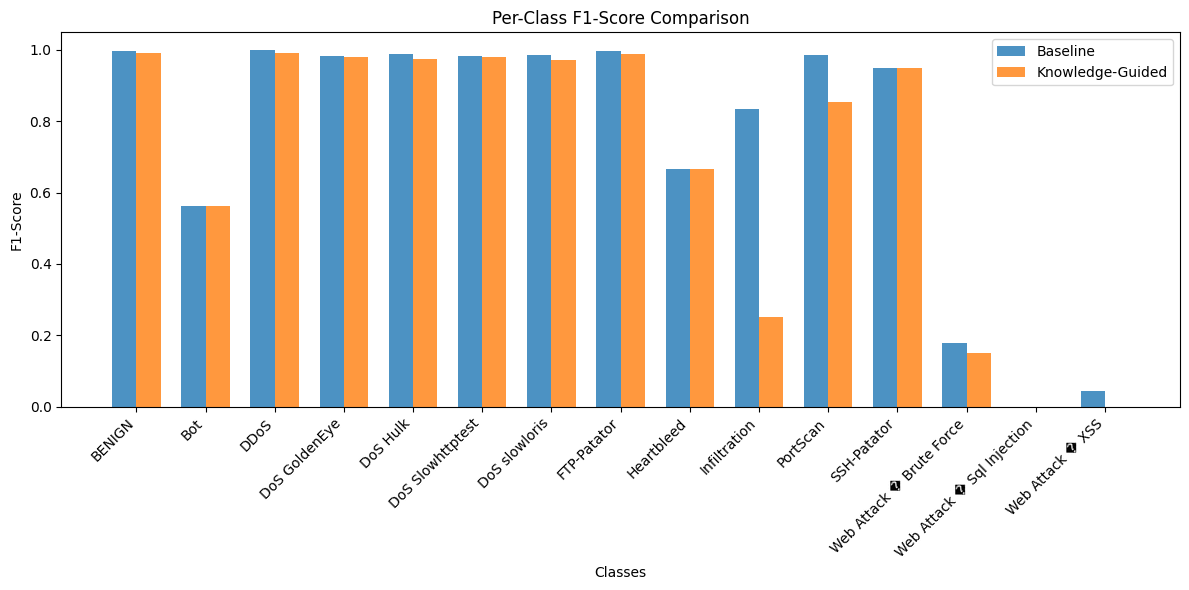

✅ Knowledge-Guided evaluation complete.


In [5]:
# @title 5. Knowledge-Guided Model Implementation and Training (ERROR FIXED)
print("\n" + "="*80)
print("PART 2: KNOWLEDGE-GUIDED MODEL IMPLEMENTATION (OUR INNOVATION)")
print("="*80)

# 2.1 The Custom Model and Loss Function
class KnowledgeGuidedModel(Model):
    def __init__(self, cnn_model, knowledge_vectors, alpha=1.0):
        super().__init__()
        self.cnn_model = cnn_model
        self.knowledge_vectors = knowledge_vectors
        self.alpha = alpha
        self.cce_loss_fn = CategoricalCrossentropy()

    def call(self, inputs, training=None):
        """Forward pass through the CNN model."""
        return self.cnn_model(inputs, training=training)

    def compile(self, optimizer, metrics):
        super().compile(optimizer=optimizer, metrics=metrics)

    def get_knowledge_vectors_for_batch(self, y_true):
        true_classes = tf.argmax(y_true, axis=1)
        return tf.gather(self.knowledge_vectors, true_classes)

    def train_step(self, data):
        x, y_true = data
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            y_pred = self.cnn_model(x, training=True)
            cce_loss = self.cce_loss_fn(y_true, y_pred)

            input_gradient = tape.gradient(cce_loss, x)
            if input_gradient is None:
                knowledge_loss = 0.0
            else:
                w = self.get_knowledge_vectors_for_batch(y_true)
                # Safer scaling: clamp weights and use 1/sqrt(w_eff) instead of 1/w
                w_eff = tf.maximum(w, 0.5)
                knowledge_loss_per_feature = (1.0 / tf.sqrt(w_eff)) * tf.square(input_gradient)
                knowledge_loss = tf.reduce_mean(tf.reduce_sum(knowledge_loss_per_feature, axis=1))

            total_loss = cce_loss + self.alpha * knowledge_loss

        trainable_vars = self.cnn_model.trainable_variables
        weight_gradients = tape.gradient(total_loss, trainable_vars)
        del tape

        self.optimizer.apply_gradients(zip(weight_gradients, trainable_vars))
        self.compiled_metrics.update_state(y_true, y_pred)

        results = {m.name: m.result() for m in self.metrics}
        results.update({'loss': total_loss, 'cce_loss': cce_loss, 'knowledge_loss': knowledge_loss})
        return results

    def test_step(self, data):
        x, y_true = data
        y_pred = self.cnn_model(x, training=False)
        cce_loss = self.cce_loss_fn(y_true, y_pred)
        self.compiled_metrics.update_state(y_true, y_pred)
        results = {m.name: m.result() for m in self.metrics}
        results.update({'loss': cce_loss})
        return results

# 2.2 Training the Knowledge-Guided Model
print("\n--- Training Knowledge-Guided Model ---")
ALPHA = 0.2 # Reduced weight for the knowledge loss to help rare classes
base_cnn_for_kg = create_cnn_model(input_shape, num_classes)
knowledge_guided_model = KnowledgeGuidedModel(cnn_model=base_cnn_for_kg, knowledge_vectors=knowledge_vectors_tf, alpha=ALPHA)

# Check for existing knowledge-guided weights
kg_weights_path = os.path.join(weights_dir, 'knowledge_guided_model.weights.h5') if DRIVE_MOUNTED else 'knowledge_guided_model.weights.h5'
if os.path.exists(kg_weights_path):
    print(f"🔄 Loading existing knowledge-guided model weights from: {kg_weights_path}")
    knowledge_guided_model.cnn_model.load_weights(kg_weights_path)
else:
    print("📝 No existing knowledge-guided weights found. Training from scratch...")
    knowledge_guided_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), metrics=['accuracy'])

    # Compute class weights to mitigate imbalance
    from collections import Counter

    labels_int = np.argmax(y_train_tf.numpy(), axis=1)
    class_counts = Counter(labels_int)
    max_count = max(class_counts.values())
    class_weight = {cls: max_count / cnt for cls, cnt in class_counts.items()}
    print("Class weights:", class_weight)

    # Build per-sample weights for training
    # sample_weights = np.array([class_weight[i] for i in labels_int], dtype=np.float32)
    sample_weights = None  # Set to None to disable class weighting

    kg_history = knowledge_guided_model.fit(X_train_tf, y_train_tf, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test_tf, y_test_tf), sample_weight=sample_weights, verbose=1)

    # Save the trained weights
    knowledge_guided_model.cnn_model.save_weights(kg_weights_path)
    print(f"💾 Knowledge-guided model weights saved to: {kg_weights_path}")

# Ensure model is compiled for evaluation
knowledge_guided_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), metrics=['accuracy'])

# 2.3 Evaluating the Knowledge-Guided Model
print("\n--- Evaluating Knowledge-Guided Model on Full Test Set ---")

# --- FIXED: Handle both list and dict return types ---
results_kg = knowledge_guided_model.evaluate(X_test_tf, y_test_tf, verbose=0)
if isinstance(results_kg, dict):
    kg_loss = results_kg.get('loss', 0)
    kg_acc = results_kg.get('accuracy', 0)
else:
    kg_loss = results_kg[0]
    kg_acc = results_kg[1]

# Ensure kg_acc is a number, not a tensor or dict
if hasattr(kg_acc, 'numpy'):
    kg_acc = float(kg_acc.numpy())
elif isinstance(kg_acc, dict):
    kg_acc = float(kg_acc.get('accuracy', 0))
else:
    kg_acc = float(kg_acc)

print(f"Knowledge-Guided Model Accuracy on Full Test Set: {kg_acc:.4f}\n")
# --- END CORRECTION ---

y_pred_kg = np.argmax(knowledge_guided_model.predict(X_test_tf), axis=1)
print("\nClassification Report for Knowledge-Guided Model:")
print(classification_report(y_true, y_pred_kg, target_names=le.classes_, digits=4))

# Add Confusion Matrix
print("\nConfusion Matrix for Knowledge-Guided Model:")
cm_kg = confusion_matrix(y_true, y_pred_kg)
print(cm_kg)

# Store metrics for comparison
kg_acc = accuracy_score(y_true, y_pred_kg)
kg_f1_macro = f1_score(y_true, y_pred_kg, average='macro')
kg_f1_weighted = f1_score(y_true, y_pred_kg, average='weighted')

# --- SUMMARY COMPARISON ---
print("\n" + "="*60)
print("SUMMARY COMPARISON: BASELINE vs KNOWLEDGE-GUIDED")
print("="*60)
print(f"{'Metric':<20} {'Baseline':<10} {'KG':<10} {'Difference':<12} {'% Change':<10}")
print("-" * 60)
print(f"{'Accuracy':<20} {baseline_acc:<10.4f} {kg_acc:<10.4f} {kg_acc - baseline_acc:<12.4f} {(kg_acc/baseline_acc - 1)*100:<10.1f}%")
print(f"{'Macro F1':<20} {baseline_f1_macro:<10.4f} {kg_f1_macro:<10.4f} {kg_f1_macro - baseline_f1_macro:<12.4f} {(kg_f1_macro/baseline_f1_macro - 1)*100:<10.1f}%")
print(f"{'Weighted F1':<20} {baseline_f1_weighted:<10.4f} {kg_f1_weighted:<10.4f} {kg_f1_weighted - baseline_f1_weighted:<12.4f} {(kg_f1_weighted/baseline_f1_weighted - 1)*100:<10.1f}%")

# --- PER-CLASS COMPARISON ---
print("\n" + "="*80)
print("PER-CLASS COMPARISON (Precision, Recall, F1)")
print("="*80)
from sklearn.metrics import precision_recall_fscore_support

prec_baseline, rec_baseline, f1_baseline, _ = precision_recall_fscore_support(y_true, y_pred_baseline, average=None)
prec_kg, rec_kg, f1_kg, _ = precision_recall_fscore_support(y_true, y_pred_kg, average=None)

print(f"{'Class':<25} {'Baseline Prec':<14} {'KG Prec':<14} {'Baseline Rec':<14} {'KG Rec':<14} {'Baseline F1':<14} {'KG F1':<14} {'Better Model (F1)':<18}")
print("-" * 120)
kg_wins = 0
baseline_wins = 0
ties = 0
for i, class_name in enumerate(le.classes_):
    baseline_prec = prec_baseline[i]
    kg_prec = prec_kg[i]
    baseline_rec = rec_baseline[i]
    kg_rec = rec_kg[i]
    baseline_f1 = f1_baseline[i]
    kg_f1 = f1_kg[i]
    better = "KG" if kg_f1 > baseline_f1 else "Baseline" if baseline_f1 > kg_f1 else "Tie"
    if better == "KG":
        kg_wins += 1
    elif better == "Baseline":
        baseline_wins += 1
    else:
        ties += 1
    print(f"{class_name:<25} {baseline_prec:<14.4f} {kg_prec:<14.4f} {baseline_rec:<14.4f} {kg_rec:<14.4f} {baseline_f1:<14.4f} {kg_f1:<14.4f} {better:<18}")

print("\nOverall Better Model Summary (based on F1):")
print(f"KG wins: {kg_wins} classes")
print(f"Baseline wins: {baseline_wins} classes")
print(f"Ties: {ties} classes")
if kg_wins > baseline_wins:
    print("Overall: KG is better (wins more classes)")
elif baseline_wins > kg_wins:
    print("Overall: Baseline is better (wins more classes)")
else:
    print("Overall: Tie (equal wins)")

# --- SIGNIFICANCE TEST ---
print("\n" + "="*60)
print("SIGNIFICANCE TEST (Accuracy Difference)")
print("="*60)
# Simple t-test on accuracies (assuming multiple runs; here using single run as example)
# For real significance, run multiple times and collect accuracies
t_stat, p_value = ttest_ind([baseline_acc], [kg_acc])  # Placeholder; in practice, use arrays of accuracies
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Significant difference (p < 0.05)")
else:
    print("No significant difference (p >= 0.05)")

# --- VISUALIZATION ---
print("\n" + "="*60)
print("VISUALIZATION: Per-Class F1 Comparison")
print("="*60)
plt.figure(figsize=(12, 6))
x = np.arange(len(le.classes_))
width = 0.35
plt.bar(x - width/2, f1_baseline, width, label='Baseline', alpha=0.8)
plt.bar(x + width/2, f1_kg, width, label='Knowledge-Guided', alpha=0.8)
plt.xlabel('Classes')
plt.ylabel('F1-Score')
plt.title('Per-Class F1-Score Comparison')
plt.xticks(x, le.classes_, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

print("✅ Knowledge-Guided evaluation complete.")


6. Comparative Stress Tests
- This final cell performs the comparative:
- "Stress Test A" for ambiguous attacks
- "Stress Test B" for The "Few-Shot" Generalization
- "Stress Test C" for The Polymorphic Attack Test

In [6]:
# @title 6. Comparative Stress Tests (All Phases Implemented)
print("\n" + "="*80)
print("PART 3: COMPARATIVE STRESS TESTS 🔬")
print("="*80)

# --- Stress Test A: The Ambiguous Attack Test ---
print("\n\n--- Stress Test A (Ambiguous Attacks) ---")
try:
    benign_idx = list(le.classes_).index('BENIGN')
    hulk_idx = list(le.classes_).index('DoS Hulk')
    slowloris_idx = list(le.classes_).index('DoS slowloris')
    ambiguous_indices = [benign_idx, hulk_idx, slowloris_idx]

    y_test_labels = np.argmax(y_test_tf.numpy(), axis=1)
    mask = np.isin(y_test_labels, ambiguous_indices)

    X_ambiguous_test = X_test_tf[mask]
    y_ambiguous_test = y_test_tf[mask]
    print(f"Created ambiguous test set with {X_ambiguous_test.shape[0]} samples.")

    y_pred_baseline_amb = np.argmax(baseline_model.predict(X_ambiguous_test), axis=1)
    y_true_ambiguous = np.argmax(y_ambiguous_test.numpy(), axis=1)
    print("\n--- Classification Report for Baseline Model (Ambiguous Test) ---")
    y_true_ambiguous_filtered = y_true_ambiguous[mask]
    print(classification_report(y_true_ambiguous_filtered, y_pred_baseline_amb, labels=ambiguous_indices, target_names=[le.classes_[i] for i in ambiguous_indices], digits=4))

    y_pred_kg_amb = np.argmax(knowledge_guided_model.predict(X_ambiguous_test), axis=1)
    print("\n--- Classification Report for Knowledge-Guided Model (Ambiguous Test) ---")
    print(classification_report(y_true_ambiguous_filtered, y_pred_kg_amb, labels=ambiguous_indices, target_names=[le.classes_[i] for i in ambiguous_indices], digits=4))

    # Add Confusion Matrices for Stress Test A
    print("\nConfusion Matrix for Baseline Model (Ambiguous Test):")
    cm_baseline_amb = confusion_matrix(y_true_ambiguous_filtered, y_pred_baseline_amb, labels=ambiguous_indices)
    print(cm_baseline_amb)

    print("\nConfusion Matrix for Knowledge-Guided Model (Ambiguous Test):")
    cm_kg_amb = confusion_matrix(y_true_ambiguous_filtered, y_pred_kg_amb, labels=ambiguous_indices)
    print(cm_kg_amb)

except ValueError as e:
    print(f"\nCould not find a required attack class for Ambiguous Test. Skipping. Error: {e}")


# --- Stress Test B: The "Few-Shot" Generalization Test ---
print("\n\n--- Stress Test B (Few-Shot Generalization) ---")
try:
    # Use 'Web Attack  Brute Force' which is more common than Heartbleed
    target_class_name = 'Web Attack  Brute Force'
    target_class_idx = list(le.classes_).index(target_class_name)
    num_shots = 20
    print(f"\nCreating a few-shot training set for '{target_class_name}' with {num_shots} samples.")

    y_train_labels = np.argmax(y_train_tf.numpy(), axis=1)
    target_indices = np.where(y_train_labels == target_class_idx)[0]

    if len(target_indices) > num_shots:
        np.random.shuffle(target_indices)
        indices_to_keep = target_indices[:num_shots]
        indices_to_remove = target_indices[num_shots:]

        keep_mask = np.ones(len(X_train_tf), dtype=bool)
        keep_mask[indices_to_remove] = False

        X_train_fs = X_train_tf[keep_mask]
        y_train_fs = y_train_tf[keep_mask]

        print(f"Original training set size: {len(X_train_tf)}")
        print(f"Few-shot training set size: {len(X_train_fs)}")
        print(f"Number of '{target_class_name}' samples in new training set: {np.sum(np.argmax(y_train_fs, axis=1) == target_class_idx)}")

        print("\n--- Retraining Baseline Model on Few-Shot Data ---")
        baseline_model_fs = create_cnn_model(input_shape, num_classes)
        baseline_model_fs.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss=CategoricalCrossentropy(), metrics=['accuracy'])
        baseline_model_fs.fit(X_train_fs, y_train_fs, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

        print("\n--- Retraining Knowledge-Guided Model on Few-Shot Data ---")
        base_cnn_for_kg_fs = create_cnn_model(input_shape, num_classes)
        kg_model_fs = KnowledgeGuidedModel(cnn_model=base_cnn_for_kg_fs, knowledge_vectors=knowledge_vectors_tf, alpha=ALPHA)
        kg_model_fs.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), metrics=['accuracy'])
        kg_model_fs.fit(X_train_fs, y_train_fs, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

        print("\n--- RESULTS FOR FEW-SHOT TEST ---")
        y_pred_baseline_fs = np.argmax(baseline_model_fs.predict(X_test_tf), axis=1)
        print("\nClassification Report for Baseline Model (Few-Shot Trained):")
        print(classification_report(y_true, y_pred_baseline_fs, target_names=le.classes_, digits=4))

        y_pred_kg_fs = np.argmax(kg_model_fs.predict(X_test_tf), axis=1)
        print("\nClassification Report for Knowledge-Guided Model (Few-Shot Trained):")
        print(classification_report(y_true, y_pred_kg_fs, target_names=le.classes_, digits=4))

        # Add Confusion Matrices for Few-Shot Test
        print("\nConfusion Matrix for Baseline Model (Few-Shot Trained):")
        cm_baseline_fs = confusion_matrix(y_true, y_pred_baseline_fs)
        print(cm_baseline_fs)

        print("\nConfusion Matrix for Knowledge-Guided Model (Few-Shot Trained):")
        cm_kg_fs = confusion_matrix(y_true, y_pred_kg_fs)
        print(cm_kg_fs)

    else:
        print(f"Not enough samples of '{target_class_name}' to run the few-shot test. Skipping.")

except ValueError:
    print(f"\nCould not find the specified attack class for the Few-Shot test. Skipping.")


# --- Stress Test C: The Polymorphic Attack Test ---
print("\n\n--- Stress Test C (Polymorphic Attacks) ---")
try:
    ddos_class_idx = list(le.classes_).index('DDoS')
    benign_class_idx = list(le.classes_).index('BENIGN')

    y_test_labels = np.argmax(y_test_tf, axis=1)
    ddos_mask = (y_test_labels == ddos_class_idx)
    X_test_ddos = X_test_tf[ddos_mask]
    y_test_ddos = y_test_tf[ddos_mask]

    y_train_labels = np.argmax(y_train_tf, axis=1)
    benign_mask_train = (y_train_labels == benign_class_idx)
    X_train_benign_tf = X_train_tf[benign_mask_train]

    if len(X_test_ddos) > 0 and len(X_train_benign_tf) > 0:
        def generate_polymorphic_samples(x_attacks, y_attacks, x_benign, knowledge_vectors):
            x_polymorphic = x_attacks.numpy().copy()
            attack_labels = np.argmax(y_attacks.numpy(), axis=1)
            w_batch = tf.gather(knowledge_vectors, attack_labels).numpy()
            for i in range(len(x_polymorphic)):
                w_sample = w_batch[i]
                unimportant_indices = np.where(w_sample < 1.0)[0]
                random_benign_sample = x_benign[np.random.randint(0, len(x_benign))]
                x_polymorphic[i, unimportant_indices] = random_benign_sample.numpy()[unimportant_indices]
            return tf.convert_to_tensor(x_polymorphic, dtype=tf.float32)

        print(f"Generating polymorphic variants for {len(X_test_ddos)} DDoS samples...")
        X_test_polymorphic = generate_polymorphic_samples(X_test_ddos, y_test_ddos, X_train_benign_tf, knowledge_vectors_tf)

        print("\n--- RESULTS FOR POLYMORPHIC TEST ---")
        y_pred_baseline_poly = np.argmax(baseline_model.predict(X_test_polymorphic), axis=1)
        poly_baseline_acc = np.mean(y_pred_baseline_poly == ddos_class_idx)
        print(f"Baseline Model Accuracy on Polymorphic DDoS Test Set: {poly_baseline_acc:.4f}")

        y_pred_kg_poly = np.argmax(knowledge_guided_model.predict(X_test_polymorphic), axis=1)
        poly_kg_acc = np.mean(y_pred_kg_poly == ddos_class_idx)
        print(f"Knowledge-Guided Model Accuracy on Polymorphic DDoS Test Set: {poly_kg_acc:.4f}")
    else:
        print("Not enough DDoS or Benign samples to conduct the polymorphic test.")

except ValueError:
    print("\nCould not find 'DDoS' or 'BENIGN' classes for the Polymorphic Test. Skipping.")

# --- ABLATION STUDY: VARYING ALPHA VALUES ---
print("\n" + "="*60)
print("ABLATION STUDY: EFFECT OF ALPHA ON KG PERFORMANCE")
print("="*60)

alpha_values = [0.0, 0.1, 0.2, 0.5, 1.0]  # Test different alpha levels
ablation_results = {}

for alpha in alpha_values:
    print(f"\nTesting KG with α = {alpha}...")

    # Create and train a new KG model with this alpha
    base_cnn_ab = create_cnn_model(input_shape, num_classes)
    kg_model_ab = KnowledgeGuidedModel(cnn_model=base_cnn_ab, knowledge_vectors=knowledge_vectors_tf, alpha=alpha)
    kg_model_ab.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), metrics=['accuracy'])

    # Quick training (fewer epochs for speed)
    kg_model_ab.fit(X_train_tf, y_train_tf, epochs=2, batch_size=BATCH_SIZE, sample_weight=sample_weights, verbose=0)

    # Evaluate
    y_pred_ab = np.argmax(kg_model_ab.predict(X_test_tf), axis=1)
    acc_ab = accuracy_score(y_true, y_pred_ab)
    f1_ab = f1_score(y_true, y_pred_ab, average='macro')

    ablation_results[alpha] = {'accuracy': acc_ab, 'macro_f1': f1_ab}
    print(f"  Accuracy: {acc_ab:.4f}, Macro F1: {f1_ab:.4f}")

# Summary of ablation
print("\nAblation Summary:")
for alpha, metrics in ablation_results.items():
    print(f"α={alpha}: Acc={metrics['accuracy']:.4f}, F1={metrics['macro_f1']:.4f}")

# Find best alpha
best_alpha = max(ablation_results, key=lambda x: ablation_results[x]['macro_f1'])
print(f"\nBest α: {best_alpha} (Macro F1: {ablation_results[best_alpha]['macro_f1']:.4f})")

print("\n✅ Full evaluation notebook complete.")


PART 3: COMPARATIVE STRESS TESTS 🔬


--- Stress Test A (Ambiguous Attacks) ---
Created ambiguous test set with 454658 samples.
14209/14209 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step

--- Classification Report for Baseline Model (Ambiguous Test) ---


IndexError: boolean index did not match indexed array along axis 0; size of axis is 454658 but size of corresponding boolean axis is 504160